# Visitor Prediction in the Library of buisness administration (BWI)

**Lecture:** Selected Topics in AI<br>
**Lecturer:** Prof. Dr. Johannes Maucher

**Group:**
- Firaz Ilhan
- Patryk Gadziomski

<div style="width: 100%; height: 30px; background-color:red"></div>

**Projektbeschreibung:**

Für das Projekt in "Selected Topics of AI" haben wir uns dazu entschieden, für die BWI-Bibliothek (Bibliothek des Betriebswirtschaftlichen Instituts) der Universität Stuttgart eine Besuchervorhersage zu machen.

**Daten:** Besucherstatistik der BWI-Bibliothek

**Ziel:** Zukünftige Besucheranzahl vorhersagen

**Methode:** Bauen und Training eines LSTM-Models

<img src="./img/workflow.png" width="700px"/>

## 0. Import Requirements and set the device

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from meteostat import Point, Daily
import holidays
import torch
import torch.nn as nn
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from copy import deepcopy as dc

Für das Ausführen des Models, sowie das Training wird die GPU benutzt. Falls diese nicht vorhanden sein sollte, wird stattdessen die CPU benutzt.

In [58]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 1. Data Exploration

In diesem Schritt werden die Daten geladen und näher betrachtet.
Bei den Daten handelt es sich um selbst erfasste Daten aus der BWI-Bibliothek der Universität Stuttgart. Diese stellen die Besucheranzahl der BWI-Bibliothek dar.

Auf den ersten Blick wird klar, das die Daten sehr veile "Missing Values" aufweisen.
Diese müssen im weiteren Vorgehen gefüllt werden.

In [59]:
# Read excel file as dataframe: visitor_data
visitor_data = pd.read_excel("data/bwi_library_visitor_data.xlsx")
visitor_data.head()

,timestemp,value
0,2022-03-28 09:30:00,NaN
1,2022-03-28 10:45:00,NaN
2,2022-03-28 13:45:00,NaN
3,2022-03-28 16:15:00,NaN
4,2022-03-28 17:45:00,NaN


In [60]:
visitor_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4896 entries, 0 to 4895
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestemp  4896 non-null   datetime64[ns]
 1   value      3782 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 76.6 KB


In [61]:
visitor_data.describe()

,value
count,3782.000000
mean,2.870968
std,3.526116
min,0.000000
25%,0.000000
50%,2.000000
75%,5.000000
max,20.000000


<Axes: xlabel='timestemp'>

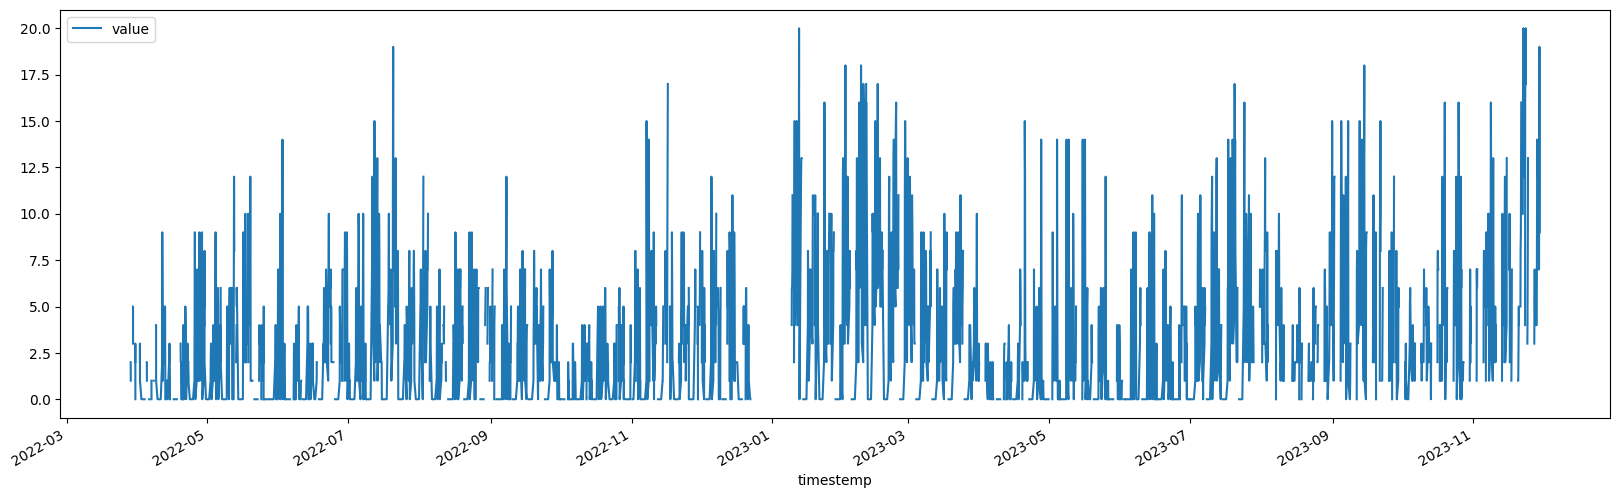

In [62]:
visitor_data.plot(x="timestemp", y="value", figsize=(20, 6))

In [63]:
visitor_data.isnull().sum()

timestemp       0
value        1114
dtype: int64

## 2. Data Preprocessing

Im Preprocessing Schritt geht es darum die fehlende Werte zu ergänzen.
Für das Auffüllen der fehlenden Werte wird die `backfill`-Methode eingesetzt, welche die fehlenden Werte anhand der vergangenen Werte auffüllt.

In [64]:
# Missing Values Handling
visitor_data['value'] = visitor_data['value'].fillna(value=None, method='backfill', axis=None, limit=None, downcast=None)

<Axes: xlabel='timestemp'>

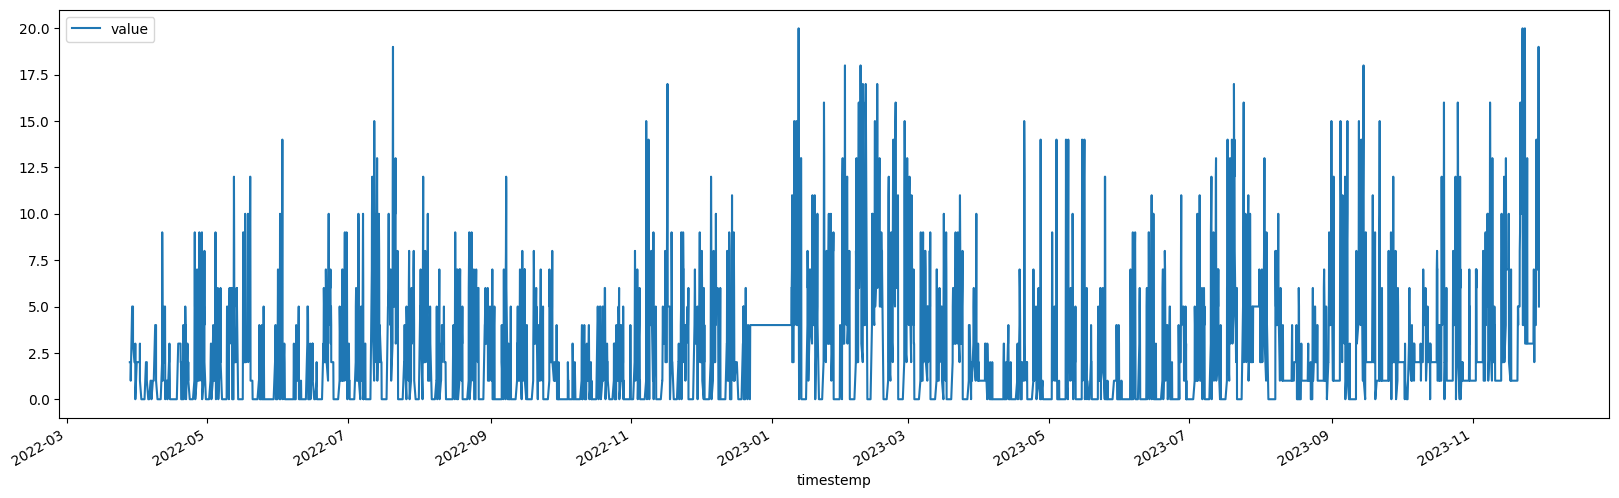

In [65]:
visitor_data.plot(x="timestemp", y="value", figsize=(20, 6))

## 3. Feature Selection and further Preprocessing

Anhand der vorhandenen feautures ("timestemp") werden weitere features extrahiert:

- Datum
- Wochentag
- Wochenende
- Prüfungsphase
- Ferien/Feiertage
- Wetterdaten
- t-1 Sequenzen

Außerdem werden für den Input des LSTM-Models die Sequenzen erstellt, welche die werte der letzten zwei Wochen beinhalten.

In [66]:
# das Datum extrahieren
date_list = []

for i in visitor_data["timestemp"]:
    new_date = (str(i)[0:10])
    new_date = datetime.datetime.strptime(new_date,'%Y-%m-%d')
    date_list.append(new_date)

visitor_data["date"] = date_list
visitor_data.head()

,timestemp,value,date
0,2022-03-28 09:30:00,2.0,2022-03-28
1,2022-03-28 10:45:00,2.0,2022-03-28
2,2022-03-28 13:45:00,2.0,2022-03-28
3,2022-03-28 16:15:00,2.0,2022-03-28
4,2022-03-28 17:45:00,2.0,2022-03-28


In [67]:
# add column "weekday"
visitor_data["weekday"] = [weekday for weekday in visitor_data["timestemp"].dt.dayofweek]
visitor_data.head()

,timestemp,value,date,weekday
0,2022-03-28 09:30:00,2.0,2022-03-28,0
1,2022-03-28 10:45:00,2.0,2022-03-28,0
2,2022-03-28 13:45:00,2.0,2022-03-28,0
3,2022-03-28 16:15:00,2.0,2022-03-28,0
4,2022-03-28 17:45:00,2.0,2022-03-28,0


In [68]:
# Check if weekday or weekend
weekend_list = []

for timestemp in visitor_data['weekday']:
    if timestemp == 5 or timestemp == 6:
        weekend_list.append(1)
    else:
        weekend_list.append(0)

visitor_data['weekend'] = weekend_list
visitor_data.head()

,timestemp,value,date,weekday,weekend
0,2022-03-28 09:30:00,2.0,2022-03-28,0,0
1,2022-03-28 10:45:00,2.0,2022-03-28,0,0
2,2022-03-28 13:45:00,2.0,2022-03-28,0,0
3,2022-03-28 16:15:00,2.0,2022-03-28,0,0
4,2022-03-28 17:45:00,2.0,2022-03-28,0,0


In [69]:
# Set all values, where weekend day is 1 to 0
visitor_data.loc[visitor_data['weekend'].eq(1), 'value'] = 0

In [70]:
# Vorlesungsphase = 0, Pfürungsphase = 1
exam_phase_ws_2021_begin = datetime.datetime(2022, 2, 10)
exam_phase_ws_2021_end = datetime.datetime(2022, 3, 31)

exam_phase_ss_2022_begin = datetime.datetime(2022, 7, 20)
exam_phase_ss_2022_end = datetime.datetime(2022, 9, 30)

exam_phase_ws_2022_begin = datetime.datetime(2023, 2, 10)
exam_phase_ws_2022_end = datetime.datetime(2023, 3, 31)

exam_phase_ss_2023_begin = datetime.datetime(2023, 7, 20)
exam_phase_ss_2023_end = datetime.datetime(2023, 9, 30)

exam_phase_ws_2023_begin = datetime.datetime(2024, 2, 10)
exam_phase_ws_2023_end = datetime.datetime(2024, 3, 31)

In [71]:
# Exam Phase
exam_phase_list = []

for timestemp in visitor_data['timestemp']:
    if timestemp >= exam_phase_ws_2021_begin and timestemp <= exam_phase_ws_2021_end:
        exam_phase_list.append(1)
    elif timestemp >= exam_phase_ss_2022_begin and timestemp <= exam_phase_ss_2022_end:
        exam_phase_list.append(1)
    elif timestemp >= exam_phase_ws_2022_begin and timestemp <= exam_phase_ws_2022_end:
        exam_phase_list.append(1)
    elif timestemp >= exam_phase_ss_2023_begin and timestemp <= exam_phase_ss_2023_end:
        exam_phase_list.append(1)
    elif timestemp >= exam_phase_ws_2023_begin and timestemp <= exam_phase_ws_2023_end:
        exam_phase_list.append(1)
    else:
        exam_phase_list.append(0)

exam_phase_list

visitor_data['exam_phase'] = exam_phase_list
visitor_data.head()

,timestemp,value,date,weekday,weekend,exam_phase
0,2022-03-28 09:30:00,2.0,2022-03-28,0,0,1
1,2022-03-28 10:45:00,2.0,2022-03-28,0,0,1
2,2022-03-28 13:45:00,2.0,2022-03-28,0,0,1
3,2022-03-28 16:15:00,2.0,2022-03-28,0,0,1
4,2022-03-28 17:45:00,2.0,2022-03-28,0,0,1


In [72]:
# Check if holiday, or not; holiday = 1, else = 0

de_holidays = holidays.country_holidays('DE', subdiv='BW')

holiday_array = []

for date in visitor_data['date']:
    if date in de_holidays:
        holiday_array.append(1)
    else:
        holiday_array.append(0)

visitor_data['holiday'] = holiday_array

visitor_data.loc[visitor_data['holiday'].eq(1), 'value'] = 0
visitor_data.head()

,timestemp,value,date,weekday,weekend,exam_phase,holiday
0,2022-03-28 09:30:00,2.0,2022-03-28,0,0,1,0
1,2022-03-28 10:45:00,2.0,2022-03-28,0,0,1,0
2,2022-03-28 13:45:00,2.0,2022-03-28,0,0,1,0
3,2022-03-28 16:15:00,2.0,2022-03-28,0,0,1,0
4,2022-03-28 17:45:00,2.0,2022-03-28,0,0,1,0


In [73]:
# Set the values of the winter vacations to 0, and holiday to 1

wv_begin_2022 = datetime.datetime(2022, 12, 23)
wv_end_2022 = datetime.datetime(2023, 1, 8)

wv_begin_2023 = datetime.datetime(2023, 12, 23)
wv_end_2023 = datetime.datetime(2024, 1, 7)

wv_list = []

for timestemp in visitor_data['timestemp']:
    if timestemp >= wv_begin_2022 and timestemp <= wv_end_2022:
        wv_list.append(1)
    elif timestemp >= wv_begin_2023 and timestemp <= wv_end_2023:
        wv_list.append(1)
    else:
        wv_list.append(0)

visitor_data['winter_vacation'] = wv_list

visitor_data.loc[visitor_data['winter_vacation'].eq(1), 'value'] = 0
visitor_data.loc[visitor_data['winter_vacation'].eq(1), 'holiday'] = 1

visitor_data.head()

,timestemp,value,date,weekday,weekend,exam_phase,holiday,winter_vacation
0,2022-03-28 09:30:00,2.0,2022-03-28,0,0,1,0,0
1,2022-03-28 10:45:00,2.0,2022-03-28,0,0,1,0,0
2,2022-03-28 13:45:00,2.0,2022-03-28,0,0,1,0,0
3,2022-03-28 16:15:00,2.0,2022-03-28,0,0,1,0,0
4,2022-03-28 17:45:00,2.0,2022-03-28,0,0,1,0,0


In [74]:
# Die Vergangeheitswerte t-1 etc. bekommen
def prepare_dateframe_for_lstm(df, n_steps):
    # use a copy instead of the original data frame object 
    df = df.copy()

    cols = [df['value'].shift(i).rename(f'value (t-{i})') for i in range(1, n_steps + 1)]
    
    df = pd.concat([df] + cols, axis=1)
    
    df.dropna(inplace=True)
    
    return df

# wenn wir zwei Wochen übergeben wollen, müssen wir 8*14=112 Werte zurück gehen.
lookback = 112
visitor_data = prepare_dateframe_for_lstm(visitor_data, lookback)

visitor_data.head()

,timestemp,value,date,weekday,weekend,exam_phase,holiday,winter_vacation,value (t-1),value (t-2),...,value (t-103),value (t-104),value (t-105),value (t-106),value (t-107),value (t-108),value (t-109),value (t-110),value (t-111),value (t-112)
112,2022-04-11 09:30:00,2.0,2022-04-11,0,0,0,0,0,0.0,0.0,...,5.0,5.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0
113,2022-04-11 10:45:00,9.0,2022-04-11,0,0,0,0,0,2.0,0.0,...,5.0,5.0,5.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0
114,2022-04-11 13:45:00,5.0,2022-04-11,0,0,0,0,0,9.0,2.0,...,5.0,5.0,5.0,5.0,1.0,1.0,2.0,2.0,2.0,2.0
115,2022-04-11 16:15:00,5.0,2022-04-11,0,0,0,0,0,5.0,9.0,...,5.0,5.0,5.0,5.0,5.0,1.0,1.0,2.0,2.0,2.0
116,2022-04-11 17:45:00,1.0,2022-04-11,0,0,0,0,0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,1.0,1.0,2.0,2.0


In [75]:
# Get the weather data until today
today_year = int(str(datetime.datetime.today())[0:4])
today_month = int(str(datetime.datetime.today())[5:7])
today_day = int(str(datetime.datetime.today())[8:10])

# get weather data thorught the date
start = datetime.datetime(2022, 3, 28)
end = datetime.datetime(today_year, today_month, today_day)

# Stuttgart
location = Point(48.7823200, 9.1770200, 252)

weather_data = Daily(location, start, end)
weather_data = weather_data.fetch()

"""
time: The date string (format: YYYY-MM-DD)      : String
tavg: The average air temperature in °C         : Float
tmin: The minimum air temperature in °C         : Float
tmax: The maximum air temperature in °C	        : Float
prcp: The daily precipitation total in mm       : Float
snow: The maximum snow depth in mm	            : Integer
wdir: The average wind direction in degrees (°)	: Integer
wspd: The average wind speed in km/h	        : Float
wpgt: The peak wind gust in km/h	            : Float
pres: The average sea-level air pressure in hPa	: Float
tsun: The daily sunshine total in minutes (m)	: Integer
"""
weather_data.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2022-03-28,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
2022-03-29,12.6,7.0,17.4,1.8,0.0,133.0,8.6,22.7,1009.8,210.0
2022-03-30,9.0,6.9,11.2,0.8,0.0,300.0,7.2,30.6,1001.8,0.0
2022-03-31,6.4,4.5,9.0,14.9,0.0,2.0,9.7,31.7,996.7,3.0
2022-04-01,1.9,-0.2,4.5,8.7,0.0,337.0,12.2,28.1,1001.3,0.0


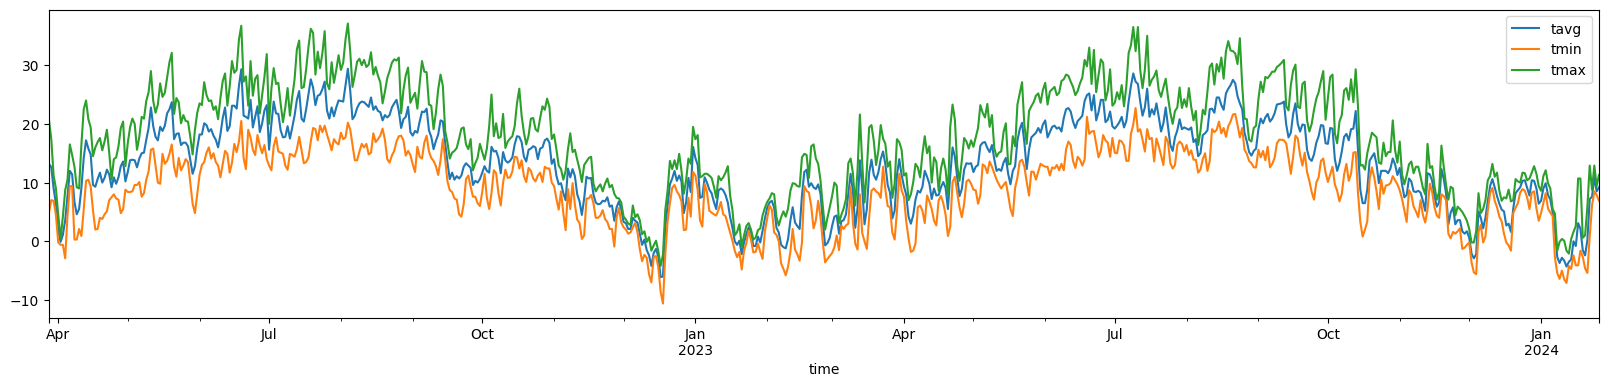

In [76]:
weather_data.plot(y=['tavg', 'tmin', 'tmax'], figsize=(20, 4))
plt.show()

<Axes: xlabel='timestemp'>

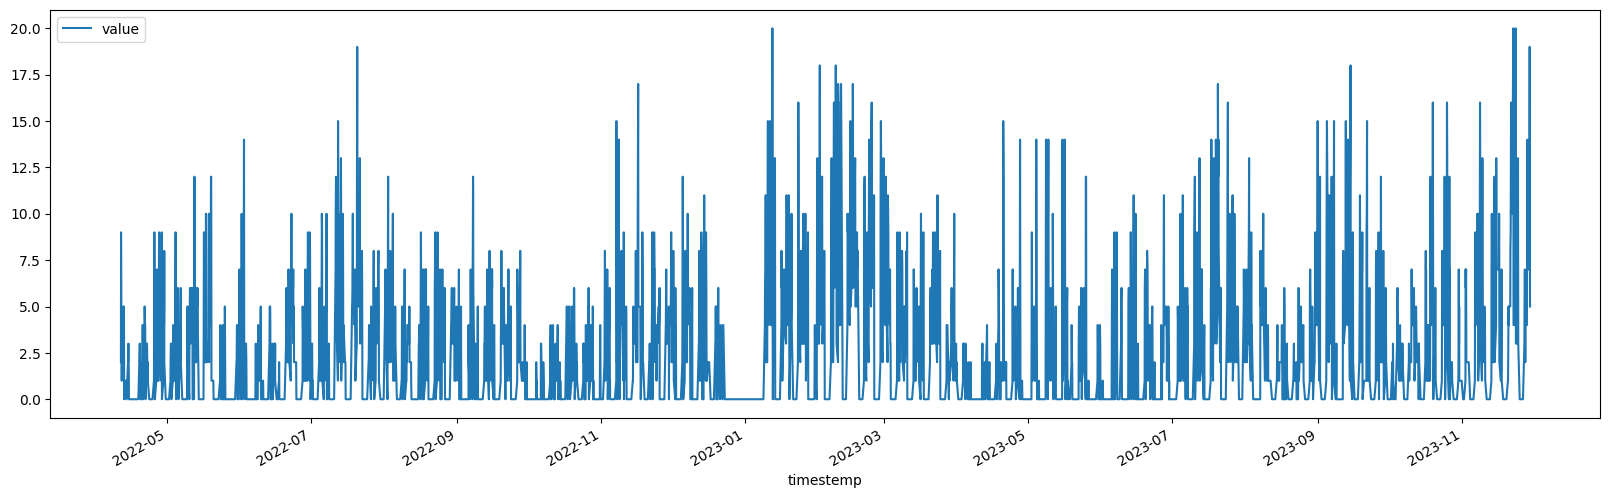

In [77]:
visitor_data.plot(x="timestemp", y="value", figsize=(20, 6))

## 4. JOIN both dataframes (visitor_data + weather_data) and calculate correlations

In [78]:
# merge data frames
visitor_data_with_weather = visitor_data.merge(
    weather_data,
    left_on="date",
    right_on="time"
)

visitor_data_with_weather.head()

,timestemp,value,date,weekday,weekend,exam_phase,holiday,winter_vacation,value (t-1),value (t-2),...,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2022-04-11 09:30:00,2.0,2022-04-11,0,0,0,0,0,0.0,0.0,...,9.1,0.9,16.5,0.0,0.0,125.0,9.0,31.0,1017.6,709.0
1,2022-04-11 10:45:00,9.0,2022-04-11,0,0,0,0,0,2.0,0.0,...,9.1,0.9,16.5,0.0,0.0,125.0,9.0,31.0,1017.6,709.0
2,2022-04-11 13:45:00,5.0,2022-04-11,0,0,0,0,0,9.0,2.0,...,9.1,0.9,16.5,0.0,0.0,125.0,9.0,31.0,1017.6,709.0
3,2022-04-11 16:15:00,5.0,2022-04-11,0,0,0,0,0,5.0,9.0,...,9.1,0.9,16.5,0.0,0.0,125.0,9.0,31.0,1017.6,709.0
4,2022-04-11 17:45:00,1.0,2022-04-11,0,0,0,0,0,5.0,5.0,...,9.1,0.9,16.5,0.0,0.0,125.0,9.0,31.0,1017.6,709.0


In [79]:
visitor_data.set_index('timestemp', inplace=True)
visitor_data_with_weather.set_index('timestemp', inplace=True)
visitor_data_with_weather.head()

,value,date,weekday,weekend,exam_phase,holiday,winter_vacation,value (t-1),value (t-2),value (t-3),...,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
timestemp,,,,,,,,,,,,,,,,,,,,,
2022-04-11 09:30:00,2.0,2022-04-11,0,0,0,0,0,0.0,0.0,0.0,...,9.1,0.9,16.5,0.0,0.0,125.0,9.0,31.0,1017.6,709.0
2022-04-11 10:45:00,9.0,2022-04-11,0,0,0,0,0,2.0,0.0,0.0,...,9.1,0.9,16.5,0.0,0.0,125.0,9.0,31.0,1017.6,709.0
2022-04-11 13:45:00,5.0,2022-04-11,0,0,0,0,0,9.0,2.0,0.0,...,9.1,0.9,16.5,0.0,0.0,125.0,9.0,31.0,1017.6,709.0
2022-04-11 16:15:00,5.0,2022-04-11,0,0,0,0,0,5.0,9.0,2.0,...,9.1,0.9,16.5,0.0,0.0,125.0,9.0,31.0,1017.6,709.0
2022-04-11 17:45:00,1.0,2022-04-11,0,0,0,0,0,5.0,5.0,9.0,...,9.1,0.9,16.5,0.0,0.0,125.0,9.0,31.0,1017.6,709.0


In [80]:
#calculate correlations between all features of data frame
data_corr = visitor_data_with_weather.corr()
data_corr

,value,weekday,weekend,exam_phase,holiday,winter_vacation,value (t-1),value (t-2),value (t-3),value (t-4),...,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
value,1.000000,-0.413847,-0.457059,0.123916,-0.172433,-0.120241,0.756579,0.540086,0.382376,0.308671,...,-0.103441,-0.096834,-0.092813,0.012443,-0.022010,-0.021816,0.026588,-0.013010,0.023043,-0.066435
weekday,-0.413847,1.000000,0.790623,0.003391,-0.054540,0.016353,-0.392329,-0.363521,-0.328039,-0.285988,...,0.002924,0.007145,-0.006256,0.009955,0.043489,0.028722,-0.022200,-0.017266,0.011624,-0.013576
weekend,-0.457059,0.790623,1.000000,-0.006960,-0.051050,0.010351,-0.446596,-0.431971,-0.416359,-0.400519,...,-0.003857,-0.003740,-0.013080,-0.004833,0.041330,0.024208,-0.003549,-0.003433,0.054399,0.004241
exam_phase,0.123916,0.003391,-0.006960,1.000000,-0.164185,-0.114489,0.124669,0.126894,0.129337,0.132770,...,0.237332,0.245624,0.249659,-0.002974,-0.061206,0.001665,0.003103,0.057805,-0.060641,0.083518
holiday,-0.172433,-0.054540,-0.051050,-0.164185,1.000000,0.697317,-0.170135,-0.167003,-0.164145,-0.161488,...,-0.059962,-0.061423,-0.066261,-0.017363,-0.025988,0.072697,0.069806,0.097528,0.088592,-0.055143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wdir,-0.021816,0.028722,0.024208,0.001665,0.072697,0.013864,-0.020457,-0.018274,-0.014757,-0.009508,...,-0.045267,0.070677,-0.115333,0.033366,-0.035022,1.000000,0.245614,0.192334,-0.089706,-0.243625
wspd,0.026588,-0.022200,-0.003549,0.003103,0.069806,0.112650,0.024490,0.026395,0.029959,0.036862,...,-0.095551,-0.047586,-0.127332,0.060973,-0.007429,0.245614,1.000000,0.739003,-0.232071,-0.196109
wpgt,-0.013010,-0.017266,-0.003433,0.057805,0.097528,0.118859,-0.012372,-0.011677,-0.007882,-0.002579,...,0.082067,0.126510,0.065082,0.256570,-0.091038,0.192334,0.739003,1.000000,-0.326898,-0.132898
pres,0.023043,0.011624,0.054399,-0.060641,0.088592,0.072758,0.023159,0.023196,0.022762,0.022626,...,-0.097614,-0.158521,-0.057287,-0.301078,0.061755,-0.089706,-0.232071,-0.326898,1.000000,0.196478


In [81]:
data_corr_label = visitor_data_with_weather.iloc[:, :].corr()["value"]
data_corr_label

value         1.000000
weekday      -0.413847
weekend      -0.457059
exam_phase    0.123916
holiday      -0.172433
                ...   
wdir         -0.021816
wspd          0.026588
wpgt         -0.013010
pres          0.023043
tsun         -0.066435
Name: value, Length: 128, dtype: float64

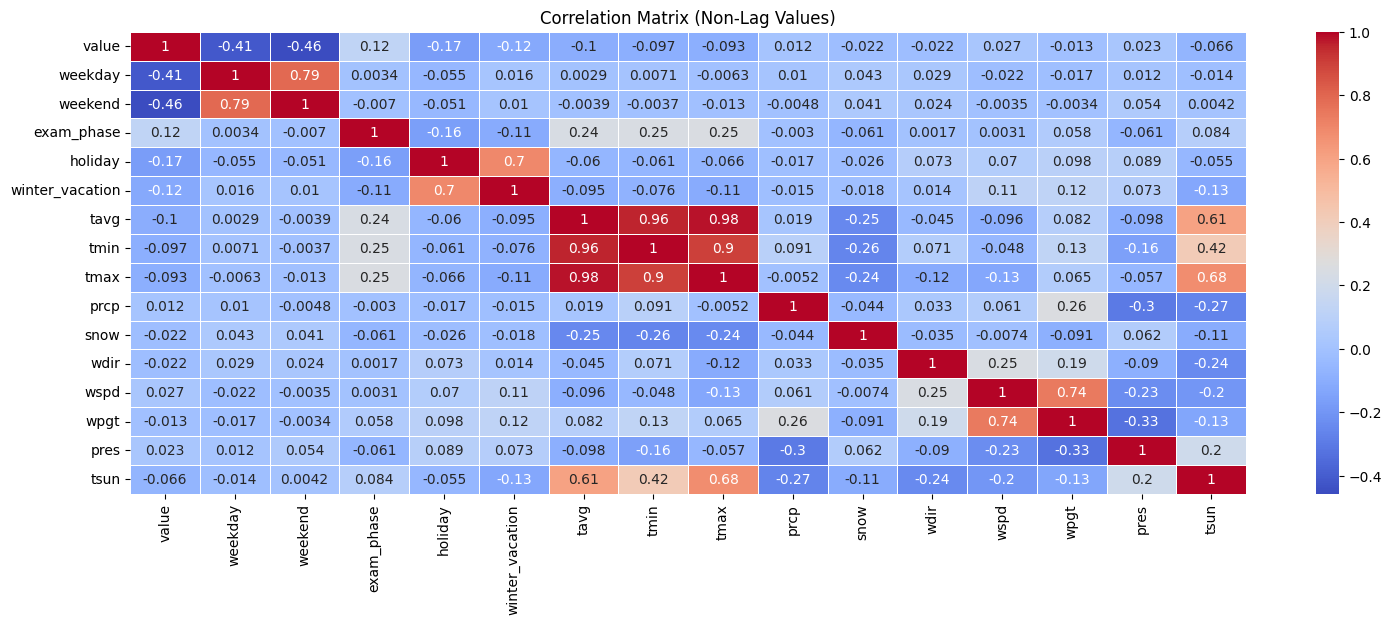

In [82]:
non_lag_columns = [col for col in data_corr.columns if "(t-" not in col]

data_corr_non_lag = data_corr[non_lag_columns].loc[non_lag_columns]

plt.figure(figsize=(18, 6))
sns.heatmap(data_corr_non_lag, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Matrix (Non-Lag Values)')
plt.show()

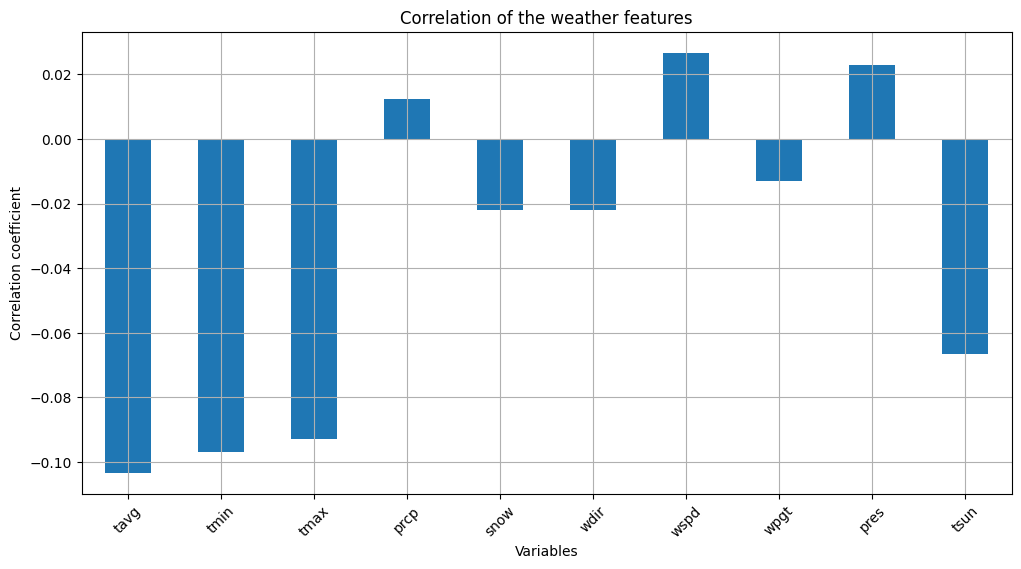

In [83]:
plt.figure(figsize=(12, 6))
data_corr_label["tavg":].plot(kind='bar')
plt.title('Correlation of the weather features')
plt.xlabel('Variables')
plt.ylabel('Correlation coefficient')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Da die Wetterdaten eine sehr niedrige Korrelation vorweisen, werden diese wieder aus dem Data Frame entfernt.

In [84]:
# drop unnecessary features
droplist = ['date', 'winter_vacation', 'weekend']
visitor_data = visitor_data.drop(droplist, axis=1)

visitor_data.head()

,value,weekday,exam_phase,holiday,value (t-1),value (t-2),value (t-3),value (t-4),value (t-5),value (t-6),...,value (t-103),value (t-104),value (t-105),value (t-106),value (t-107),value (t-108),value (t-109),value (t-110),value (t-111),value (t-112)
timestemp,,,,,,,,,,,,,,,,,,,,,
2022-04-11 09:30:00,2.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,5.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0
2022-04-11 10:45:00,9.0,0,0,0,2.0,0.0,0.0,0.0,0.0,0.0,...,5.0,5.0,5.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0
2022-04-11 13:45:00,5.0,0,0,0,9.0,2.0,0.0,0.0,0.0,0.0,...,5.0,5.0,5.0,5.0,1.0,1.0,2.0,2.0,2.0,2.0
2022-04-11 16:15:00,5.0,0,0,0,5.0,9.0,2.0,0.0,0.0,0.0,...,5.0,5.0,5.0,5.0,5.0,1.0,1.0,2.0,2.0,2.0
2022-04-11 17:45:00,1.0,0,0,0,5.0,5.0,9.0,2.0,0.0,0.0,...,5.0,5.0,5.0,5.0,5.0,5.0,1.0,1.0,2.0,2.0


## 5. Prepare Data for Model

In [85]:
visitor_data.head()

,value,weekday,exam_phase,holiday,value (t-1),value (t-2),value (t-3),value (t-4),value (t-5),value (t-6),...,value (t-103),value (t-104),value (t-105),value (t-106),value (t-107),value (t-108),value (t-109),value (t-110),value (t-111),value (t-112)
timestemp,,,,,,,,,,,,,,,,,,,,,
2022-04-11 09:30:00,2.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,5.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0
2022-04-11 10:45:00,9.0,0,0,0,2.0,0.0,0.0,0.0,0.0,0.0,...,5.0,5.0,5.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0
2022-04-11 13:45:00,5.0,0,0,0,9.0,2.0,0.0,0.0,0.0,0.0,...,5.0,5.0,5.0,5.0,1.0,1.0,2.0,2.0,2.0,2.0
2022-04-11 16:15:00,5.0,0,0,0,5.0,9.0,2.0,0.0,0.0,0.0,...,5.0,5.0,5.0,5.0,5.0,1.0,1.0,2.0,2.0,2.0
2022-04-11 17:45:00,1.0,0,0,0,5.0,5.0,9.0,2.0,0.0,0.0,...,5.0,5.0,5.0,5.0,5.0,5.0,1.0,1.0,2.0,2.0


In [86]:
visitor_data.shape

(4783, 116)

In [87]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
new_visitor_data = scaler.fit_transform(visitor_data)

new_visitor_data

array([[0.1       , 0.        , 0.        , ..., 0.1       , 0.1       ,
        0.1       ],
       [0.45      , 0.        , 0.        , ..., 0.1       , 0.1       ,
        0.1       ],
       [0.25      , 0.        , 0.        , ..., 0.1       , 0.1       ,
        0.1       ],
       ...,
       [0.45      , 0.33333333, 0.        , ..., 0.35      , 0.35      ,
        0.35      ],
       [0.25      , 0.33333333, 0.        , ..., 0.35      , 0.35      ,
        0.35      ],
       [0.25      , 0.33333333, 0.        , ..., 0.35      , 0.35      ,
        0.35      ]])

In [88]:
# Split into features and labels

data_features = new_visitor_data[:, 1:]
data_labels = new_visitor_data[:, 0]

data_features.shape, data_labels.shape

((4783, 115), (4783,))

In [89]:
data_labels

array([0.1 , 0.45, 0.25, ..., 0.45, 0.25, 0.25])

In [90]:
# Flip the data because of the order of the sequence
data_features = dc(np.flip(data_features, axis=1))
data_features

array([[0.1       , 0.1       , 0.1       , ..., 0.        , 0.        ,
        0.        ],
       [0.1       , 0.1       , 0.1       , ..., 0.        , 0.        ,
        0.        ],
       [0.1       , 0.1       , 0.1       , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.35      , 0.35      , 0.35      , ..., 0.        , 0.        ,
        0.33333333],
       [0.35      , 0.35      , 0.35      , ..., 0.        , 0.        ,
        0.33333333],
       [0.35      , 0.35      , 0.35      , ..., 0.        , 0.        ,
        0.33333333]])

In [91]:
# Train test Split
split_index = int(len(data_features) * 0.8)

train_features = data_features[:split_index]
test_features = data_features[split_index:]

train_labels = data_labels[:split_index]
test_labels = data_labels[split_index:]

In [92]:
train_features.shape, train_labels.shape, test_features.shape, test_labels.shape

((3826, 115), (3826,), (957, 115), (957,))

In [93]:
# Reshape the arrays into 3-dimeniosnal arrays.
# LSTM-Models requires a 3-dimensional input.
goback = len(visitor_data.columns) -1

train_features = train_features.reshape((-1, goback, 1))
test_features = test_features.reshape((-1, goback, 1))

train_labels = train_labels.reshape((-1, 1))
test_labels = test_labels.reshape((-1, 1))

train_features.shape, test_features.shape, train_labels.shape, test_labels.shape

((3826, 115, 1), (957, 115, 1), (3826, 1), (957, 1))

In [94]:
# Turn the data into tensors
train_features = torch.tensor(train_features).float()
train_labels = torch.tensor(train_labels).float()

test_features = torch.tensor(test_features).float()
test_labels = torch.tensor(test_labels).float()

train_features.shape, test_features.shape, train_labels.shape, test_labels.shape

(torch.Size([3826, 115, 1]),
 torch.Size([957, 115, 1]),
 torch.Size([3826, 1]),
 torch.Size([957, 1]))

## 6. Dataset and DataLoader

In [95]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(train_features, train_labels)
test_dataset = TimeSeriesDataset(test_features, test_labels)

In [96]:
train_dataset, test_dataset

(<__main__.TimeSeriesDataset at 0x1748675b8d0>,
 <__main__.TimeSeriesDataset at 0x17487f6b590>)

In [97]:
BS = 8

train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False)

for x, y in train_loader:
    print(f"Input Batch Shape: {x.shape} - (batch size, Features, scalar label)")
    print(f"Label Batch Shape: {y.shape} - (batch size, label dimension)")
    break


Input Batch Shape: torch.Size([8, 115, 1]) - (batch size, Features, scalar label)
Label Batch Shape: torch.Size([8, 1]) - (batch size, label dimension)


## 7. Build Model

### 7.1. LSTM Model Architecture

<img src="./img/lstm.png" width="700px">

https://griesshaber.pages.mi.hdm-stuttgart.de/nlp/07neuralnetworks/02RecurrentNeuralNetworks.html

In [98]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers, dropout):
        super(LSTMModel, self).__init__()

        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_layer_size = hidden_layer_size
        self.output_size = output_size
        self.dropout = dropout

        self.lstm = nn.LSTM(input_size=self.input_size, # input size
                            hidden_size=self.hidden_layer_size, # hidden layer
                            num_layers=self.num_layers, #stacked layers
                            dropout=self.dropout # dropout
                            )
        self.linear = nn.Linear(self.hidden_layer_size, self.output_size)
        
        self.hidden_cell = (
            torch.zeros(self.num_layers, 1, self.hidden_layer_size),
            torch.zeros(self.num_layers, 1, self.hidden_layer_size),
        )
    
    def forward(self, input_seq):
        input_seq_reshaped = input_seq.view(len(input_seq), 1, -1) # preprocessing

        lstm_out, self.hidden_cell = self.lstm(input_seq_reshaped, self.hidden_cell)

        lstm_out_reshaped = lstm_out.view(len(input_seq), -1)

        predictions = self.linear(lstm_out_reshaped)

        return predictions

### 7.2. Training

In [99]:
loss_list = []
input_size = goback
hidden_layer_size = 100
output_size = 1
num_layers = 2
learning_rate = 0.001
dropout = 0.1

model = LSTMModel(input_size, hidden_layer_size, output_size, num_layers, dropout)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [100]:
summary(model, input_size=(8, 115))

Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [8, 1]                    --
├─LSTM: 1-1                              [8, 1, 100]               167,600
├─Linear: 1-2                            [8, 1]                    101
Total params: 167,701
Trainable params: 167,701
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.34
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.67
Estimated Total Size (MB): 0.68

In [101]:
epochs = 3

print(f"Using: {device} for training")

for epoch in range(epochs):
    model.train()
    
    # reset the hidden state at each loop
    model.hidden_cell = (
        torch.zeros(num_layers, 1, model.hidden_layer_size),
        torch.zeros(num_layers, 1, model.hidden_layer_size),
    )

    for i, (x_batch, y_batch) in enumerate(train_loader):

        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # reset the gradients
        optimizer.zero_grad()

        # prevent backpropagating of the dataset
        model.hidden_cell = (
            model.hidden_cell[0].detach(),
            model.hidden_cell[1].detach(),
        )

        # forward pass
        y_pred = model(x_batch.float())

        # compute loss
        loss = loss_function(y_pred, y_batch.float())
        loss_list.append(loss.detach().numpy())

        # backward pass
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs} Loss: {loss.item()}")

print("Training complete")

Using: cpu for training


Epoch 1/3 Loss: 0.001672658952884376
Epoch 2/3 Loss: 0.0007909660926088691
Epoch 3/3 Loss: 0.0003286542487330735
Training complete


### 7.3. Validation

#### MSE, Root MSE, MAE

In [102]:
total_loss = 0
count = 0
actuals = []
predictions = []
test_loss = []

with torch.no_grad():
    model.train(False)
    for x_batch, y_batch in test_loader:
        
        y_pred = model(x_batch.float())

        predictions.extend(y_pred.view(-1).tolist())
        actuals.extend(y_batch.view(-1).tolist())

        loss = loss_function(y_pred, y_batch.float())
        total_loss += loss.item()
        test_loss.append(loss.item())
        count += 1

mse = total_loss / count
rmse = mse ** 0.5
actuals_np = np.array(actuals)
predictions_np = np.array(predictions)

mae = mean_absolute_error(actuals_np, predictions_np)

print(f"Mean Squared Error on test data: {mse}")
print(f"Root Mean Squared Error on test data: {rmse}")
print(f"Mean Absolute Error on test data: {mae}")

Mean Squared Error on test data: 0.017730205293628388
Root Mean Squared Error on test data: 0.13315481701248508
Mean Absolute Error on test data: 0.10527100005306794


Compared to the average number of visitors (including weekends and public holidays), the error metrics appear to be relatively low. In other words, the model's predictions are relatively accurate in comparison to the average number of visitors.

In [103]:
average_visitors = visitor_data['value'].mean()
average_visitors

2.4219109345598997

### 7.4. Evaluation

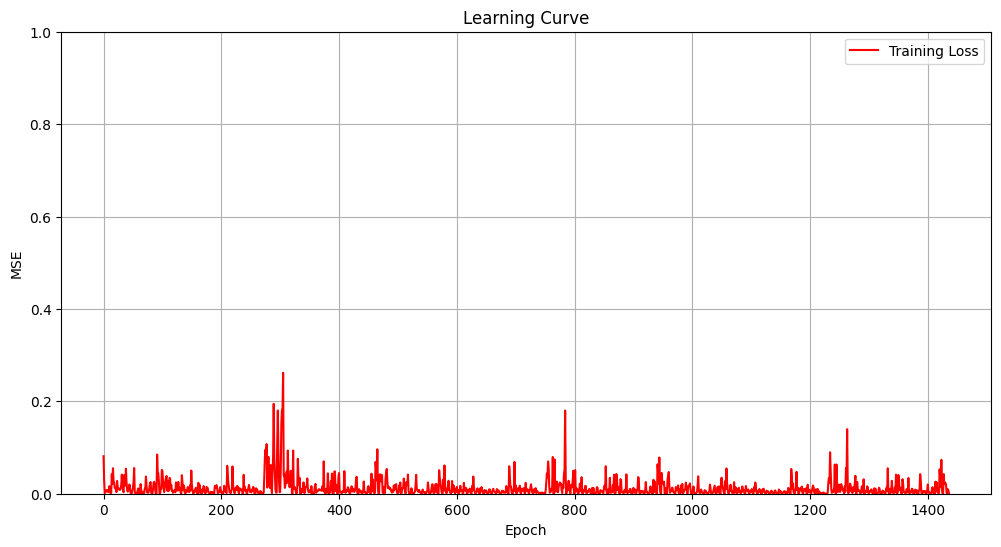

In [104]:
plt.figure(figsize=(12,6))
plt.plot(range(len(loss_list)),loss_list,"r",label="Training Loss")
plt.axis([None, None, 0, 1])
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid(True)
plt.legend()
plt.title("Learning Curve")
plt.show()

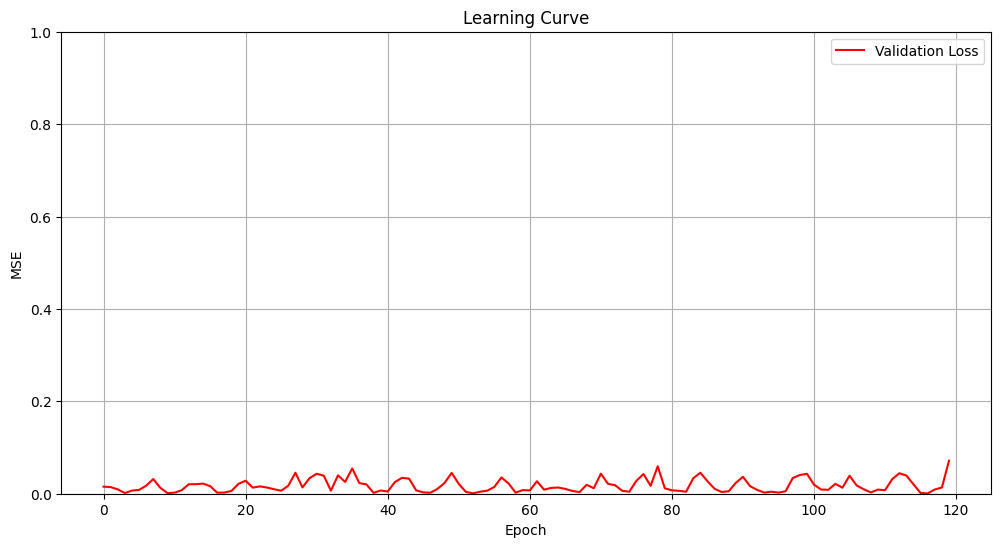

In [105]:
plt.figure(figsize=(12,6))
plt.plot(range(len(test_loss)),test_loss,"r",label="Validation Loss")
plt.axis([None, None, 0, 1])
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid(True)
plt.legend()
plt.title("Learning Curve")
plt.show()

In [106]:
test_predictions = model(test_features).detach().numpy().flatten()

dummies = np.zeros((test_features.shape[0], goback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
# test_predictions

In [107]:
dummies = np.zeros((test_features.shape[0], goback+1))
dummies[:, 0] = test_labels.flatten()
dummies = scaler.inverse_transform(dummies)

new_test_labels = dc(dummies[:, 0])
# new_test_labels

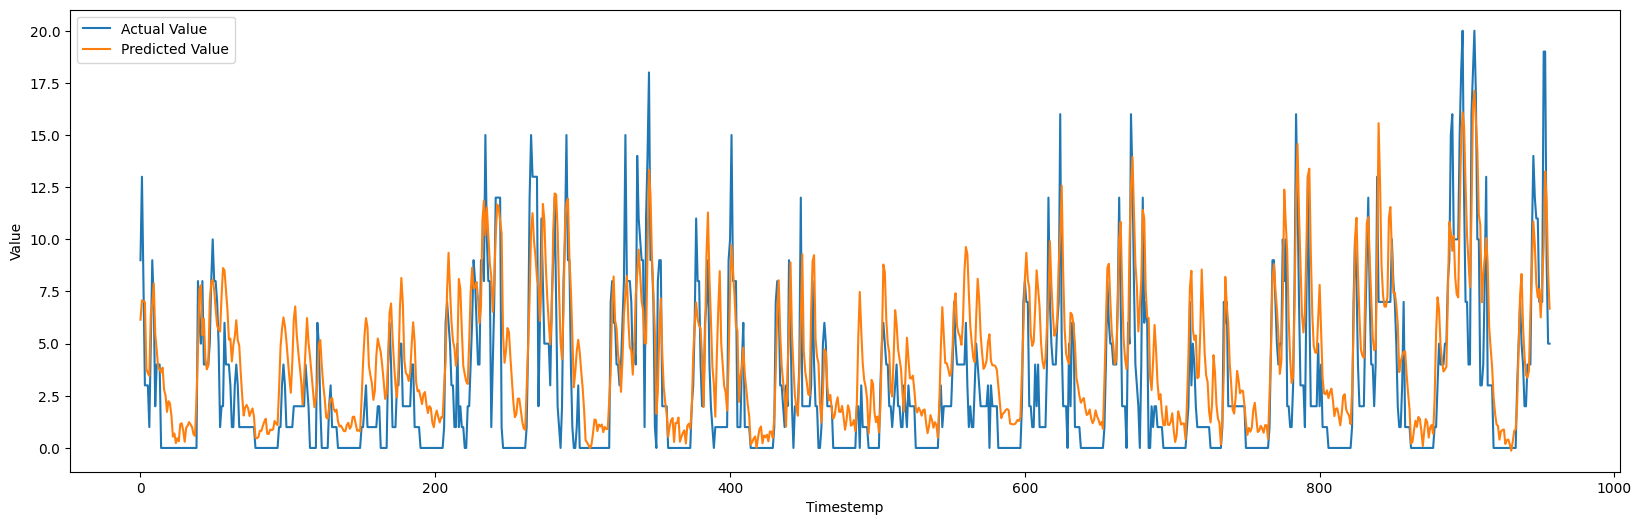

In [108]:
plt.figure(figsize=(20, 6))
plt.plot(new_test_labels, label='Actual Value')
plt.plot(test_predictions, label='Predicted Value')
plt.xlabel('Timestemp')
plt.ylabel('Value')
plt.legend()
plt.show()

# Quellen

**Recherche Quelen:**
- https://griesshaber.pages.mi.hdm-stuttgart.de/nlp/07neuralnetworks/02RecurrentNeuralNetworks.html
- https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/
- https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
- https://colah.github.io/posts/2015-08-Understanding-LSTMs/
- https://databasecamp.de/en/ml/lstms


### Verbesserungsvorschläge:
- neues Feature: Bib geöffnet = 1; Bib geschlossen = 0
- Umfrage in der Bibliothek durchführen um die Gründe fürs kommen/nicht kommen heraufinden (empirisch)